# Smart_Money_Reversal by GPT - Strategy - Backtesting 

### Import Library

In [61]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [62]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [63]:
data = dataset.copy()

In [64]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [65]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [66]:
def prepare_data(df):
    df['Liquidity_Grab'] = (df['High'] > df['High'].shift(1)) & (df['Close'] < df['Open'])
    df['Hidden_Liquidity_Absorption'] = (df['Volume'] > df['Volume'].rolling(10).mean() * 1.3) & (df['Close'].shift(1) > df['Close'])
    df['SM_Reversal_to_short'] = df['Liquidity_Grab'] & df['Hidden_Liquidity_Absorption'] & (df['Close'].shift(-1) < df['Open'].shift(-1)) & (df['Volume'] > df['Volume'].shift(1) * 0.8)
    #
    df['Liquidity_Grab2'] = (df['Low'] < df['Low'].shift(1)) & (df['Close'] > df['Open'])
    df['Hidden_Liquidity_Absorption2'] = (df['Volume'] > df['Volume'].rolling(10).mean() * 1.3) & (df['Close'].shift(1) < df['Close'])
    df['SM_Reversal_to_long'] = df['Liquidity_Grab2'] & df['Hidden_Liquidity_Absorption2'] & (df['Close'].shift(-1) > df['Open'].shift(-1)) & (df['Volume'] > df['Volume'].shift(1) * 0.8)
    return df

In [67]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [68]:
class MainStrategy(Strategy):
    reward_on_risk = 6
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        short_signal = self.data.SM_Reversal_to_short[-1]
        long_signal = self.data.SM_Reversal_to_long[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if short_signal == True:
            sell_price = close_price
            sl = sell_price + 3
            tp = sell_price - self.reward_on_risk * 3
            self.sell(size=1, sl=sl, tp=tp)
        elif long_signal == True:
            buy_price = close_price
            sl = buy_price - 3
            tp = buy_price + self.reward_on_risk * 3
            self.buy(size=1, sl=sl, tp=tp)

In [69]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [70]:
stats

Start                     2020-11-02 09:00:00
End                       2025-02-25 14:45:00
Duration                   1576 days 05:45:00
Exposure Time [%]                   19.316545
Equity Final [$]                   2584.34331
Equity Peak [$]                    2607.43932
Return [%]                          72.289554
Buy & Hold Return [%]               51.072103
Return (Ann.) [%]                   13.587887
Volatility (Ann.) [%]                5.112059
Sharpe Ratio                         2.658007
Sortino Ratio                        7.402227
Calmar Ratio                         3.563173
Max. Drawdown [%]                   -3.813424
Avg. Drawdown [%]                   -0.254089
Max. Drawdown Duration      176 days 23:55:00
Avg. Drawdown Duration        4 days 11:06:00
# Trades                                  854
Win Rate [%]                        43.911007
Best Trade [%]                       1.878676
Worst Trade [%]                     -0.451433
Avg. Trade [%]                    

In [71]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,135,151,912.87378,913.5,0.62622,0.000686,2020-11-04 13:10:00,2020-11-04 14:30:00,None,0 days 01:20:00
1,1,165,201,915.27450,912.1,-3.17450,-0.003468,2020-11-05 10:00:00,2020-11-05 14:25:00,None,0 days 04:25:00
2,1,389,398,918.97561,915.7,-3.27561,-0.003564,2020-11-11 13:05:00,2020-11-11 13:50:00,None,0 days 00:45:00
3,-1,402,404,914.92544,918.0,-3.07456,-0.003360,2020-11-11 14:10:00,2020-11-11 14:20:00,None,0 days 00:10:00
4,1,446,457,922.97681,926.5,3.52319,0.003817,2020-11-12 13:35:00,2020-11-12 14:30:00,None,0 days 00:55:00
...,...,...,...,...,...,...,...,...,...,...,...
849,-1,54299,54327,1330.00088,1332.4,-2.39912,-0.001804,2025-02-11 10:45:00,2025-02-11 14:30:00,None,0 days 03:45:00
850,1,54447,54467,1346.30377,1342.9,-3.40377,-0.002528,2025-02-14 10:20:00,2025-02-14 13:25:00,None,0 days 03:05:00
851,-1,54518,54531,1340.99758,1336.0,4.99758,0.003727,2025-02-17 13:25:00,2025-02-17 14:30:00,None,0 days 01:05:00
852,1,54628,54633,1343.40290,1345.1,1.69710,0.001263,2025-02-19 14:05:00,2025-02-19 14:30:00,None,0 days 00:25:00


In [72]:
# bt.plot()

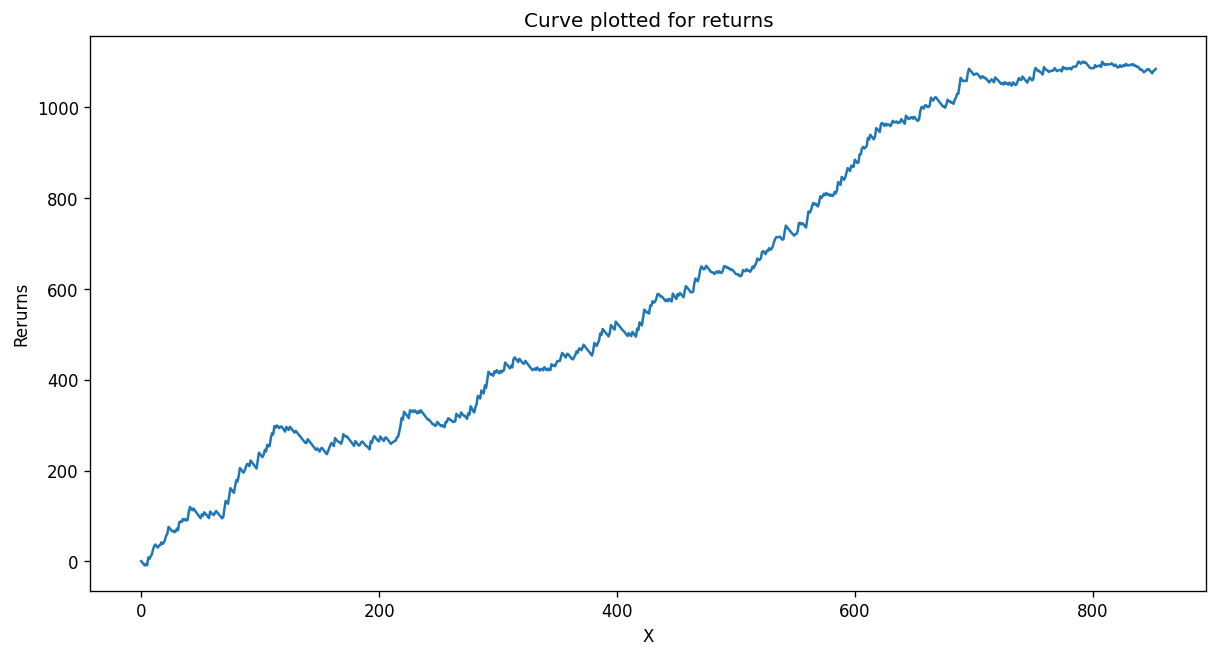

In [73]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [74]:
copy_trades['PnL'].max()

18.300579999999854

In [75]:
copy_trades['PnL'].min()

-6.21300999999994

In [76]:
copy_trades[copy_trades.EntryTime > '2025-02-01 00:00:00']['PnL'].sum()

3.4878100000000813